# Preprosesing


In [15]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [10]:
data_path = r"C:\Users\M S I\Documents\BANGKIT\train"

In [11]:
train_data = []
val_data = []
labels = []

# Loading and splitting dataset into training and validation
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    files = os.listdir(folder_path)
    num_train = int(0.8 * len(files))
    files_train = random.sample(files, num_train)
    files_val = list(set(files) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        train_data.append((img, folder))
        labels.append(folder)
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        val_data.append((img, folder))
        labels.append(folder)

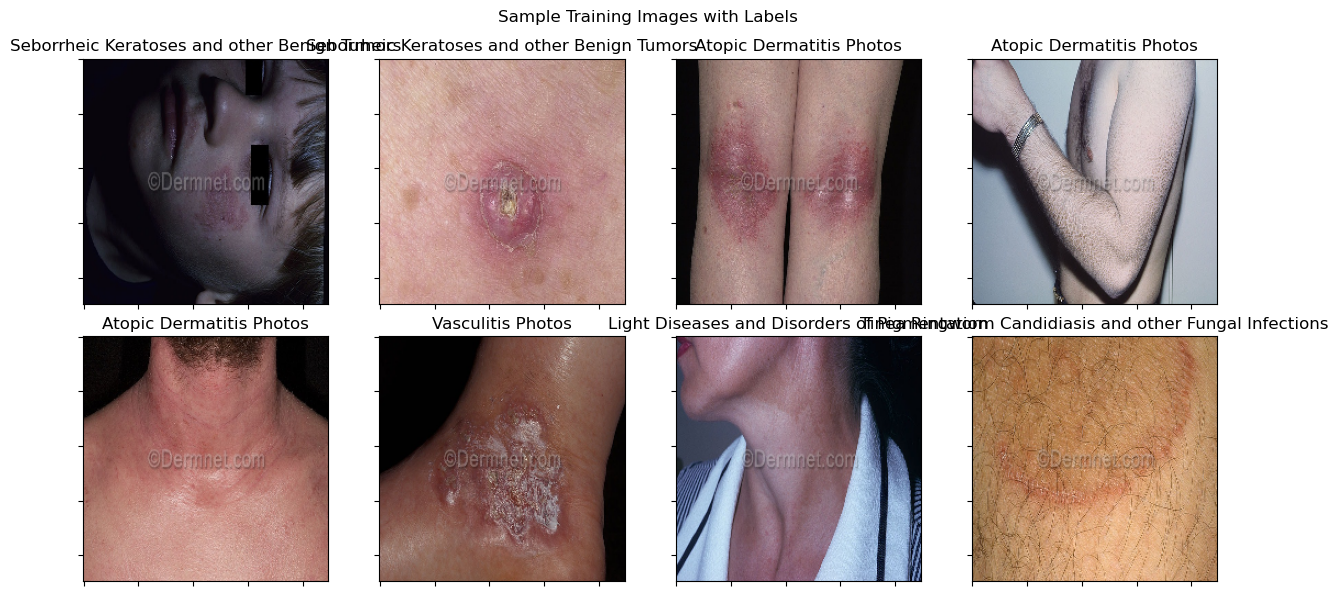

In [12]:
# Visualizing some training samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
plt.suptitle('Sample Training Images with Labels')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(False)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

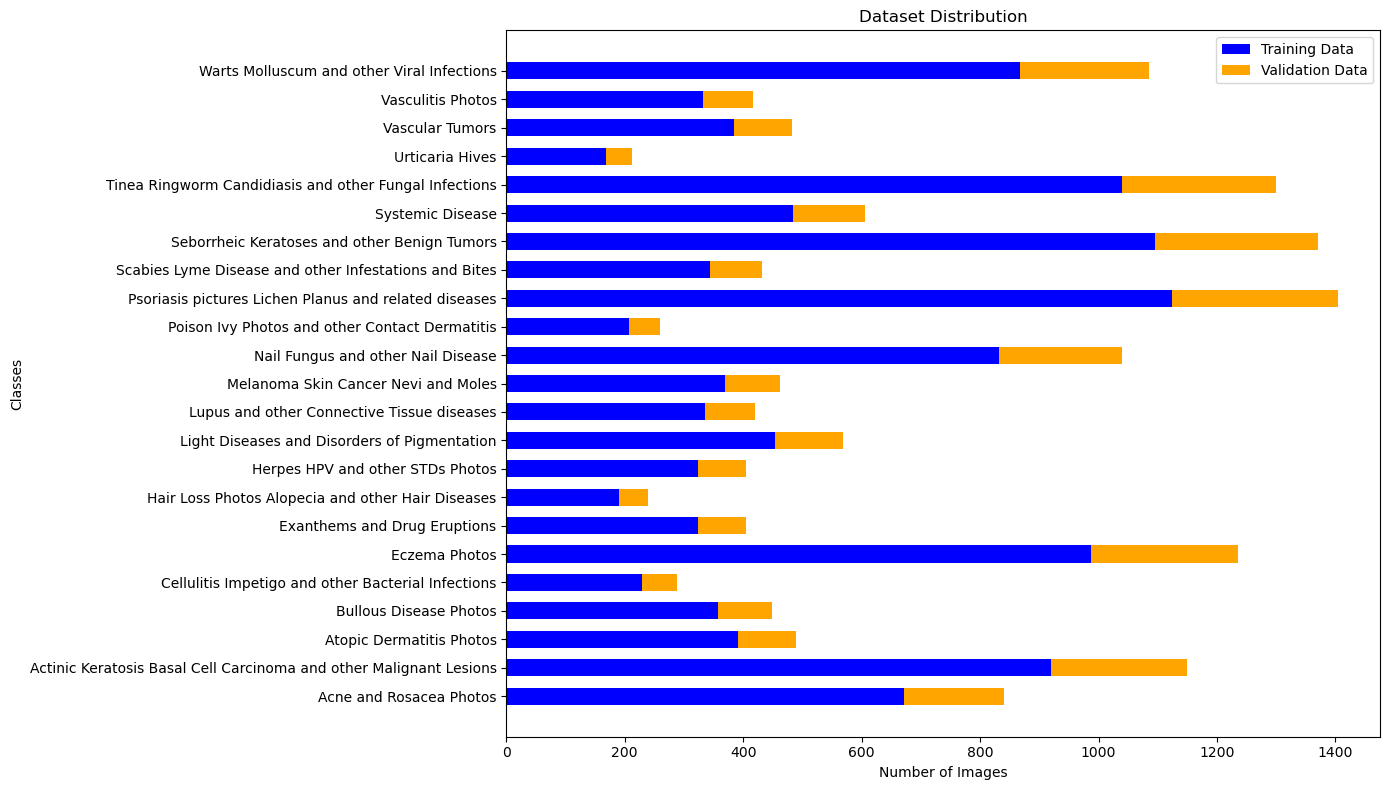

In [13]:
# Visualizing dataset distribution in a single horizontal stacked plot
train_labels = [label for _, label in train_data]
val_labels = [label for _, label in val_data]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Ensure every class appears in both train and val counts
all_classes = sorted(set(train_counts.keys()).union(val_counts.keys()))
train_counts = [train_counts.get(cls, 0) for cls in all_classes]
val_counts = [val_counts.get(cls, 0) for cls in all_classes]

fig, ax = plt.subplots(figsize=(14, 8))
bar_height = 0.6
index = np.arange(len(all_classes))

bar1 = ax.barh(index, train_counts, bar_height, label='Training Data', color='blue')
bar2 = ax.barh(index, val_counts, bar_height, left=train_counts, label='Validation Data', color='orange')

ax.set_ylabel('Classes')
ax.set_xlabel('Number of Images')
ax.set_title('Dataset Distribution')
ax.set_yticks(index)
ax.set_yticklabels(all_classes)
ax.legend()

plt.tight_layout()
plt.show()


# Build Model

In [16]:
# Building the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

num_classes = len(set(labels))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,648,599 (94.03 MB)

 Trainable params: 1,060,887 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train

In [17]:
# Preparing data for training
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [18]:
# Training the model
history = model.fit(
    X_train,
    y_train_one_hot, 
    validation_data=(X_val, y_val_one_hot),
    epochs=20, 
    batch_size=32
)


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.2427 - loss: 2.7386 - val_accuracy: 0.3466 - val_loss: 2.2092
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.4005 - loss: 2.0140 - val_accuracy: 0.3761 - val_loss: 2.0919
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.4653 - loss: 1.7646 - val_accuracy: 0.3915 - val_loss: 2.0566
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 825s 2s/step - accuracy: 0.5299 - loss: 1.5327 - val_accuracy: 0.3969 - val_loss: 2.0718
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 899s 2s/step - accuracy: 0.5853 - loss: 1.3463 - val_accuracy: 0.4210 - val_loss: 2.0566
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 938s 2s/step - accuracy: 0.6450 - loss: 1.1485 - val_accuracy: 0.4210 - val_loss: 2.0859
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.6999 - loss: 0.9857 - val_accuracy: 0.4258 - val_loss: 2.1287
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 0.7359 - loss: 0.8593 - val_accu

# Evaluate

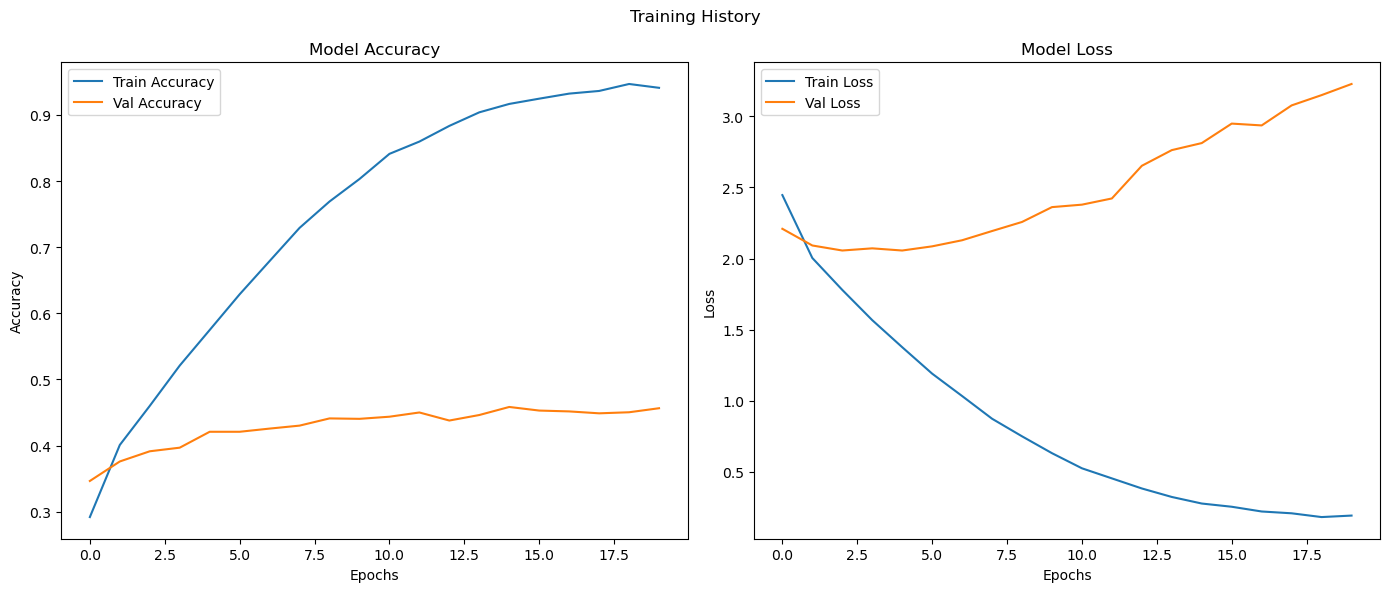

In [19]:
# Plotting training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Training History')

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [20]:
# Save the model
model.save('ModelBagusFix.h5')